# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

Populating the interactive namespace from numpy and matplotlib


/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poisson']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


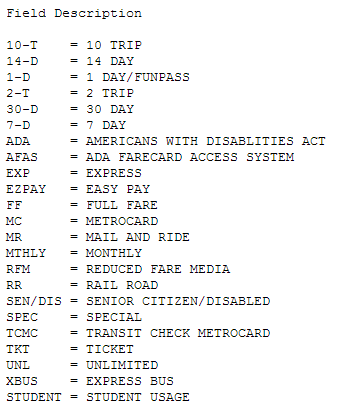

In [69]:
import pylab as pl
import numpy as np
import pandas as pd

%pylab inline

from IPython.display import Image
from IPython.display import clear_output

Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## When I ask you "what station did somethig", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "what ridership type" you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


# Possibly useful functions

## I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encounvered yet which I used. 
## (But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient

* the nupy functions np.nansum(), np.sum(), np.nanmean() etc get as parameter an array and the axis along which to sum. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...

* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, p) 
     
     which takes as arguments the length of your time series (the number of datapoints) and the sampling rate: the sampling rate is the inverse of the frequency (in this case, with 1/week sampling, if you want the freq in weeks that is just 1)



In [70]:
mta = np.load("MTA_Fare.npy")
N = mta.shape[2]

In [71]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


ride types list

In [72]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [73]:
rideindx = [np.where(ridetype == tp)[0][0] 
            for tp in ['10t', '14d', '1d', '2t', '30d', '7d', 'ez','t']]


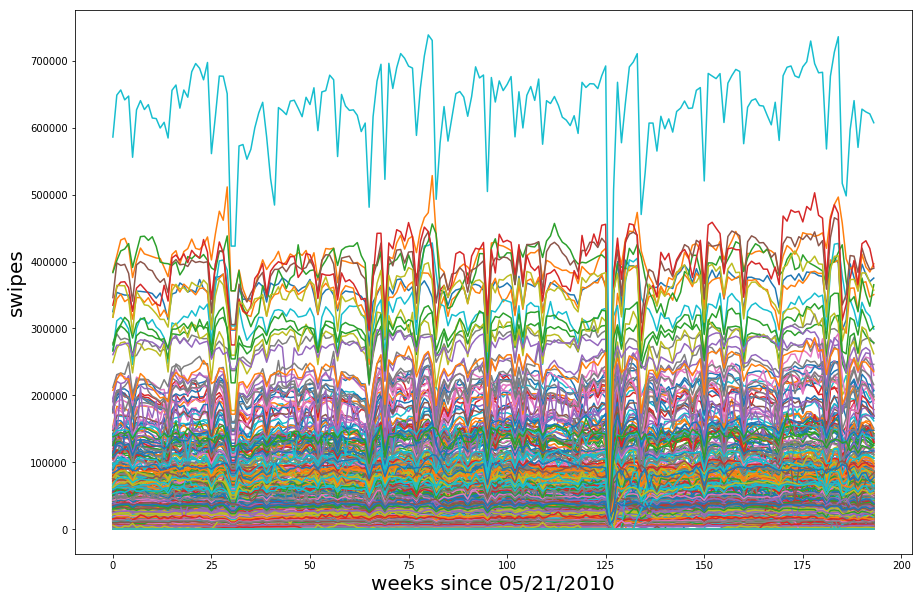

In [74]:
#plot data
pl.figure(figsize=(15,10))
for i in range(mta.shape[0]):
    allrides = [sum(mta[i,:,j]) for j in range(mta.shape[2])]
    pl.plot(allrides)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
tmp = pl.ylabel("swipes", fontsize=20)  

Figure 1: time series for all stations summed over ride type

In [75]:
rng = pd.date_range('05/21/2010', periods=N, freq='W')
print ("nominal date range given the metadata\n", rng)

nominal date range given the metadata
 DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')


Text(0,0.5,'swipes (log10)')

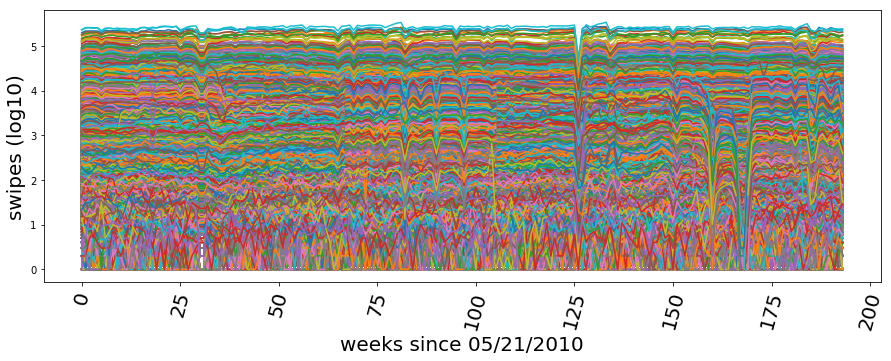

In [76]:
# plot data in log space (may take a while to plot - the counter needs to get to 23)
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
mta = mta.astype(float)
mta[mta == -1] = float('NaN')
logrides = np.log10(mta)
for j in range(mta.shape[1]):
    print (j,"/23")
    clear_output(wait=True)
    for i in range(mta.shape[0]):
        pl.plot(logrides[i,j])
pl.xticks(rotation = 75, fontsize=20)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel("swipes (log10)", fontsize=20)         

Figure 2: time series for all ride types all stations in semi-log space

In [77]:
mta_allsum = np.nansum(mta, axis=0)
print ("mta array collapsing station axis:", mta_allsum.shape)
mta_allsum = np.nansum(mta_allsum, axis=0)
print ("mta array collapsing ride type and station axes:", mta_allsum.shape)

mta array collapsing station axis: (23, 194)
mta array collapsing ride type and station axes: (194,)


In [78]:
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]

3 sigma threshold 20829468.6
outlier index (array([126]),)
outlier date DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


Text(0,0.5,'total swipes')

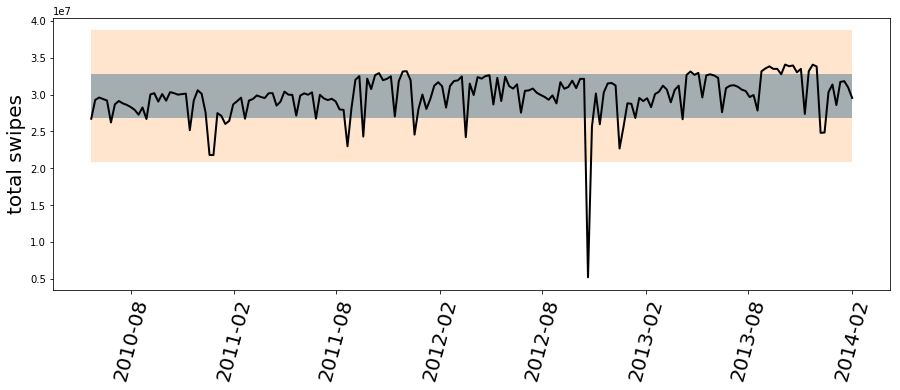

In [79]:
#plot all swipes
pl.figure(figsize=(15,5))
onesig = np.std(mta_allsum)
tsthresh = np.nanmean(mta_allsum)  - 3 * onesig
print ("3 sigma threshold %.1f"%tsthresh)
print ("outlier index", np.where(mta_allsum < tsthresh))
print ("outlier date", rng[np.where(mta_allsum < tsthresh)])
pl.fill_between(d, np.nanmean(mta_allsum) - onesig,
                np.nanmean(mta_allsum) + onesig, alpha=0.5)
pl.fill_between(d, np.nanmean(mta_allsum) - 3 * onesig,
                 np.nanmean(mta_allsum) + 3 * onesig, alpha = 0.2)
#pl.fill_between(weighted +threesigma(weighted , 10), weighted -threesigma(weighted 
pl.plot(d, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  


Figure 3a: The sum of all time series, and the three and one signa threshold indicated as shaded regions

# The outlier is near the date of sandy, but I am off by a week. I will reset the range accordingly

outlier date 2012-10-28


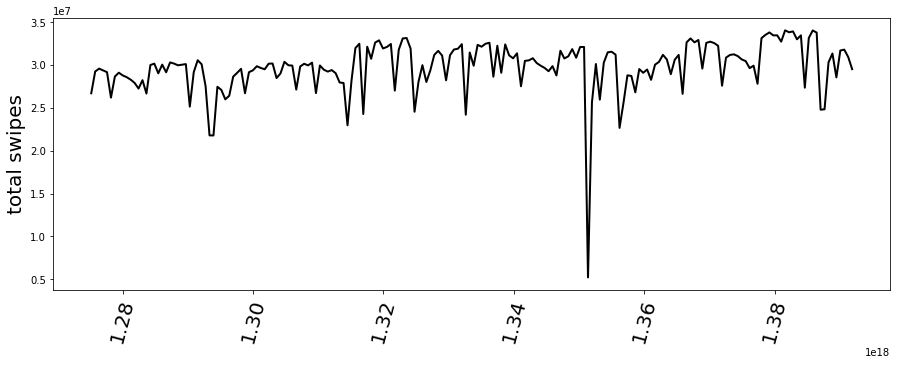

In [80]:
rng = pd.date_range('05/29/2010', periods=N, freq='W')
#plot all swipes
pl.figure(figsize=(15,5))
pl.plot(rng, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
print ("outlier date", rng[np.where(mta_allsum < tsthresh)][0].date())

Figure 3b: The sum of all time series, with corrected timeline

#use the average weighted by ticket type popularity

/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


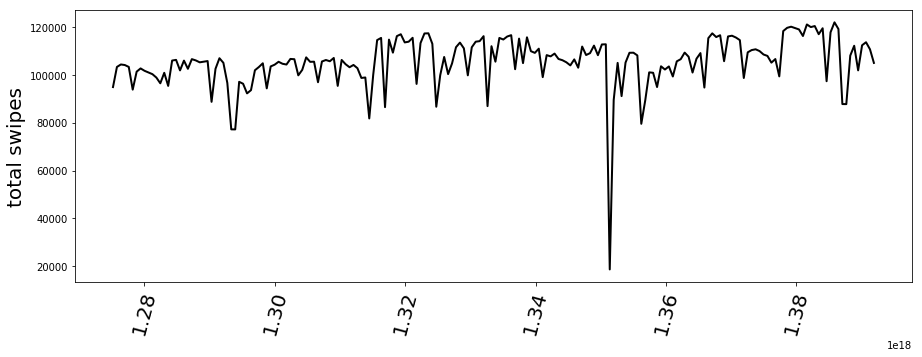

In [81]:
weightedrides = np.zeros((mta.shape[0], mta.shape[2]))

for i in range(mta.shape[0]):
    allrides = np.array([np.nansum(mta[i,:,j].flatten()) for j in range(mta.shape[2])])
    #print (allrides/nanmean(allrides)).shape, weightedrides.shape
    weightedrides[i] = allrides / np.sqrt(nanmean(allrides))
    #pl.plot(rng, np.log10(weightedrides[i]))
    #pl.xticks(rotation = 75)

    
#plot weighted by station, per ride
pl.figure(figsize=(15,5))
pl.plot(rng, np.nansum(weightedrides, axis=0), 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
rides = pd.DataFrame({'t':rng, 'ridecounts':np.nansum(weightedrides, axis=0)})

Figure 3: time series for all rides weighted by mean number of rides per station in semi-log space

### find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking ofr something that has a more or less constant trend

## to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per type. 

## you can use a rolling mean for smoothing, you can use the ratio of the flux near the beginning and the end if the time series, or fit a line to the time series and get its slope.  find series with the steepest upward trend, and the steepest downward trend.

## notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


stdev 546777.62, fractional increase over time 1.05: 
stdev 64593.90, fractional increase over time 1.33: 
stdev 5767.41, fractional increase over time 1.17: 
stdev 8828.00, fractional increase over time 0.97: 
stdev 3624.09, fractional increase over time 1.07: 
stdev 631955.02, fractional increase over time 1.46: 
stdev 473487.37, fractional increase over time 0.92: 
stdev 3794.93, fractional increase over time 0.00: 
stdev 101444.89, fractional increase over time 0.00: 
stdev 206370.78, fractional increase over time 0.00: 
stdev 18800.95, fractional increase over time 0.87: 
stdev 25371.32, fractional increase over time 1.23: 
stdev 61154.07, fractional increase over time 26332.33: 
stdev 17282.83, fractional increase over time 0.60: 
stdev 153165.98, fractional increase over time 0.65: 
stdev 33309.14, fractional increase over time 2.64: 
stdev 18139.76, fractional increase over time 2.94: 
stdev 10350.80, fractional increase over time 76.86: 
stdev 30841.45, fractional increase ove

/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


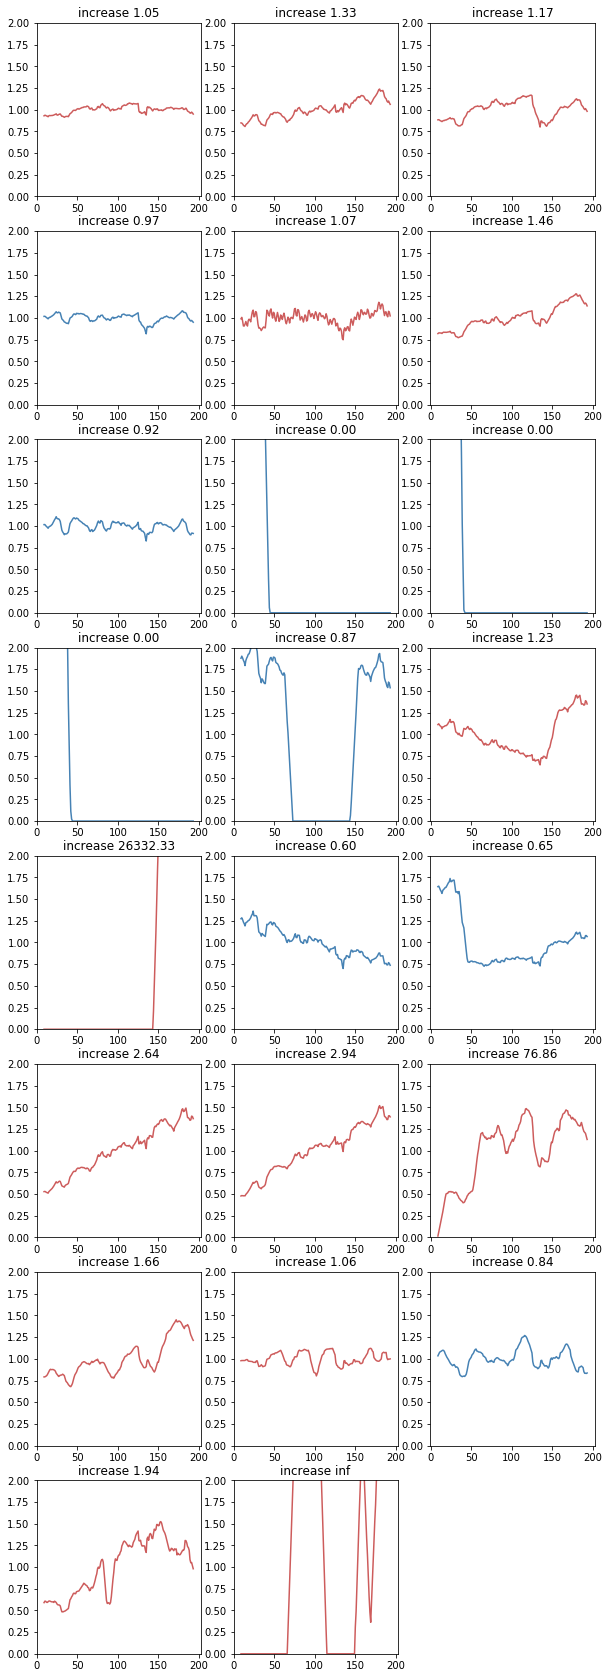

In [82]:
#remove series w bad data and store the rest in a new array
mtanew = np.empty_like(mta)
for i,m in enumerate(mta):
    for j,t in enumerate(m):
        if not -1 in t:
            mtanew[i][j] = t
mta = mtanew

increase = np.zeros((mta.shape[1],2))
fig = pl.figure(figsize=(10,30))
for i in range(mta.shape[1]):
    mta_allsum = mta[:,i,:]
    ax = fig.add_subplot(8,3,i+1)
    #rolling mean of rides by type
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    increase[i] = np.array([np.nanstd(thisride), 
                   np.nanmean(thisride[-10:]) / np.nanmean(thisride[:10])])
    print ("stdev {0:.2f}, fractional increase over time {1:.2f}: ".format(increase[i][0], 
                                                                            increase[i][1]))
    if increase[i][1] > 1:
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed")
    else: 
        pl.plot(thisride / np.nanmean(thisride), color="SteelBlue")
    pl.ylim(0,2)
    pl.title("increase %.2f"%(increase[i][1]))
        


Figure 3: time series smoothed (rolling mean w window 10), normmalized,  in semi-log space. In red are possibly increasing trends

In [83]:
trendsort = np.argsort(increase[:,1])[::-1]
print ("order of increasing trend magnitude:", trendsort)
print ("corresponding stdev:", increase[trendsort,0])


order of increasing trend magnitude: [22 12 17 16 15 21 18  5  1 11  2  4 19  0  3  6 10 20 14 13  7  8  9]
corresponding stdev: [  5.87158972e+05   6.11540734e+04   1.03507976e+04   1.81397619e+04
   3.33091354e+04   2.52041044e+02   3.08414543e+04   6.31955018e+05
   6.45939014e+04   2.53713236e+04   5.76741249e+03   3.62408853e+03
   1.57054061e+03   5.46777617e+05   8.82800386e+03   4.73487373e+05
   1.88009465e+04   6.81416737e+02   1.53165984e+05   1.72828339e+04
   3.79492677e+03   1.01444892e+05   2.06370776e+05]


# the first smooth trend is for ride type at index 16 (by visual inspection)

/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


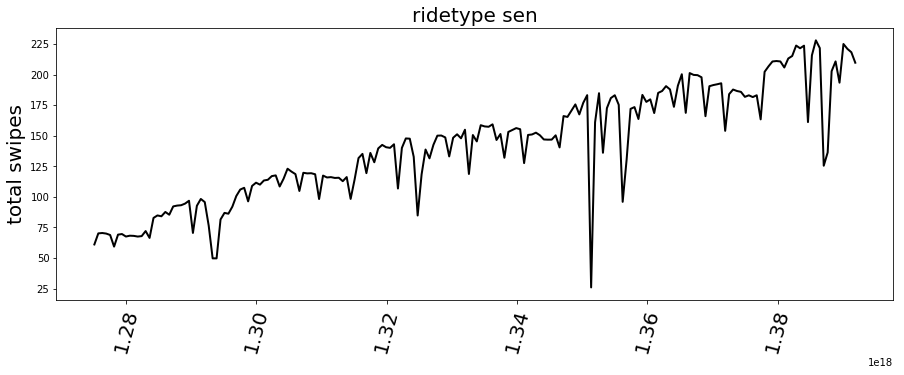

In [84]:
mtabyride = np.nanmean(mta, axis=0)
pl.figure(figsize=(15,5))
pl.plot(rng, mtabyride[16], 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
title = pl.title ("ridetype " + ridetype[16], fontsize=20)

Figure 4: the steepest smooth increase in ridership type is for Senior passes. Above is the average over all station of the senior pass popularity

In [85]:
import statsmodels.api as sm
from statsmodels.stats.gof import chisquare
models = []
selectedIndeces = [17,16,15]
for i in selectedIndeces:
    models.append(sm.OLS(mtabyride[i], 
                         sm.add_constant(np.arange(mta.shape[2]))).fit())
    #(np.nanmean(mta, axis=0)[16])
for i,m in enumerate(models):
    print (selectedIndeces[i], "R^2 line fit %.2f"%m.rsquared)

/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17 R^2 line fit 0.48
16 R^2 line fit 0.82
15 R^2 line fit 0.80


# the fit to a straight line is best for index 16 as well, confirming that Senior rides have the steepest continuous increase among ride types 

/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/fbianco/Library/Enthought/Canopy_64bit/User/envs/test_fiona/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,0,'period (weeks)')

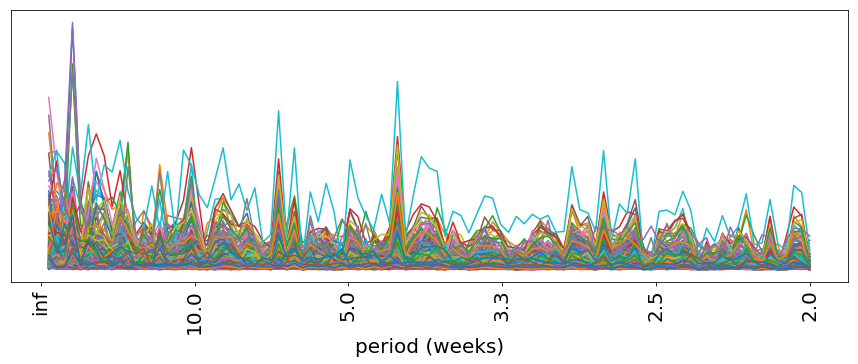

In [86]:
mtabystation = np.nanmean(mta, axis=1)
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
freqs = np.fft.rfftfreq(N, 1.0)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i])) 
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:], (this_fft[1:]))
allperiods = [1.0/N, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticklabels([ "%.1f"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)


Figure 5: Power spectrum of  rides for all stations

Text(0.5,0,'period (weeks)')

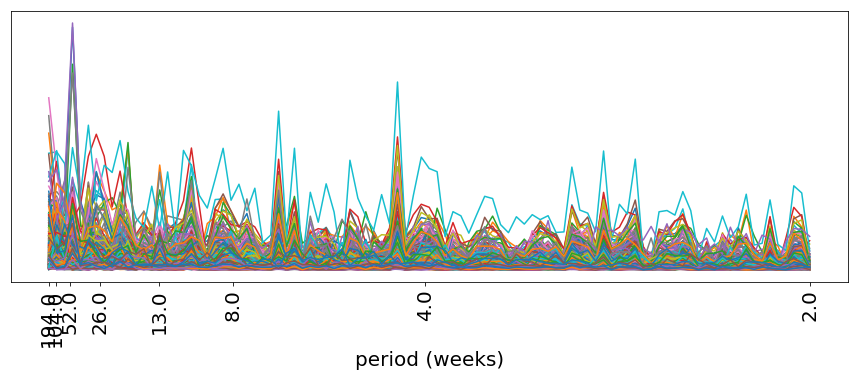

In [87]:
#plotting with a more informative set of x labels
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i]))
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:],(this_fft[1:]))
allperiods = [1.0/194, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticks (allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)


Figure 6: As figure 5, with more informative labeling of the x axis

In [88]:
yearindex = np.where(np.abs(freqs - 1.0/52) == min(np.abs(freqs - 1.0/52)))[0]
print ("index of frequency closest to %.1f weeks (%.1f)"%(1.0/freqs[yearindex], yearindex))


index of frequency closest to 48.5 weeks (4.0)


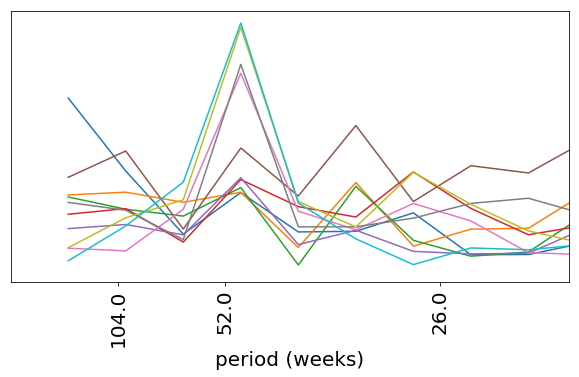

In [89]:
fig = pl.figure(figsize = (10,5))
ax = fig.add_subplot(111)

#52 weeks (or close to that) is the 4th cell of the fourier transform array. 
#I am sorting by the power in that cell and taking the indeces of the sorted array 
#(that is what argsort returns)
yearly_sorted =  np.array(this_ffts).T[4].argsort()
yearly_sorted = yearly_sorted[~np.isnan(np.array(this_ffts)[yearly_sorted[:],4])]

#print np.array(this_ffts)[yearly_sorted[-20:]]
for this_fft in np.array(this_ffts)[yearly_sorted[-10:]]:
    
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(this_fft[1:]))
allperiods = [1./104, 1.0/52, 1.0/26]
ax.set_xlim(0,0.05)
ax.set_xticks (allperiods)
ax.set_yticks ([])
tmp = ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
tmp = pl.xlabel("period (weeks)", fontsize=20)


Figure 7: Zoom-in of the power spectra of riderships for all stations around the 1-year periodicity region

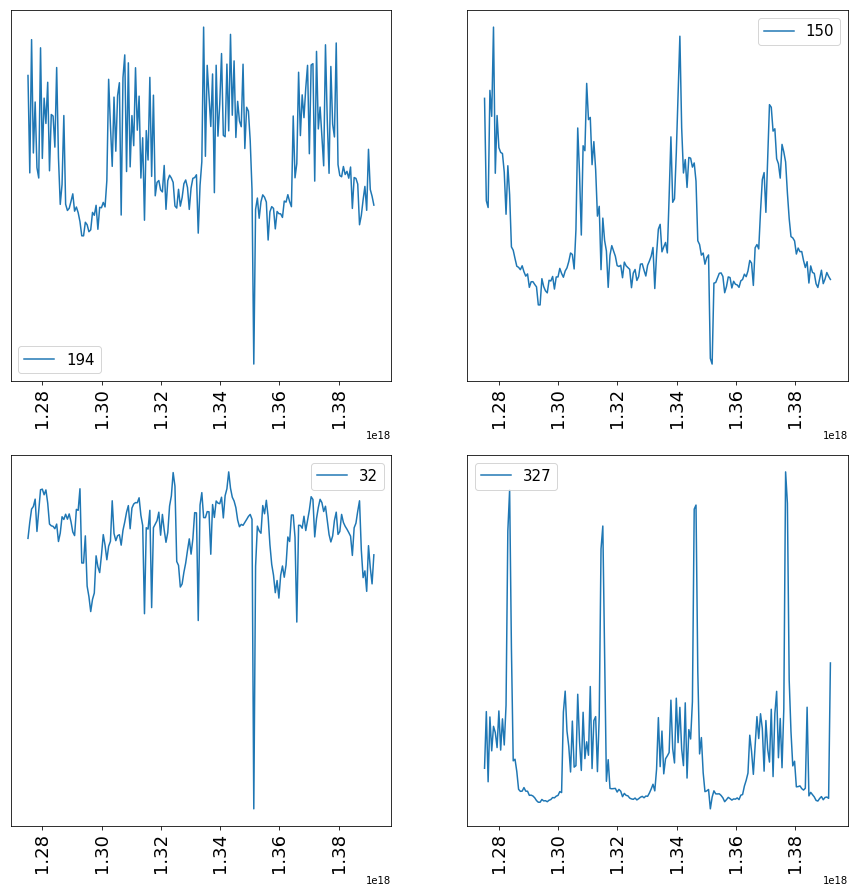

In [90]:
#plotting top 4 annually-periodic time series
fig = pl.figure(figsize=(15,15))
for i,j in enumerate(yearly_sorted[-1:-5:-1]):
    
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(rng, weightedrides[j], label="%d"%j)
    pl.legend(fontsize = 15)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_rotation('vertical')


Figure 8: The 4 station that shows the most clear periodicity at 1-year

In [92]:
from sklearn.cluster import KMeans
#clustering in 9 clusters

nc = 9
data = np.load("MTA_Fare.npy")

tots = data.transpose(2,0,1).reshape(data.shape[2], 
                                     data.shape[1]*data.shape[0]).T
# remove null time series
tots = tots[tots.std(1)>0]

km = KMeans(n_clusters=nc)

#standardizing before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

km.fit(vals)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

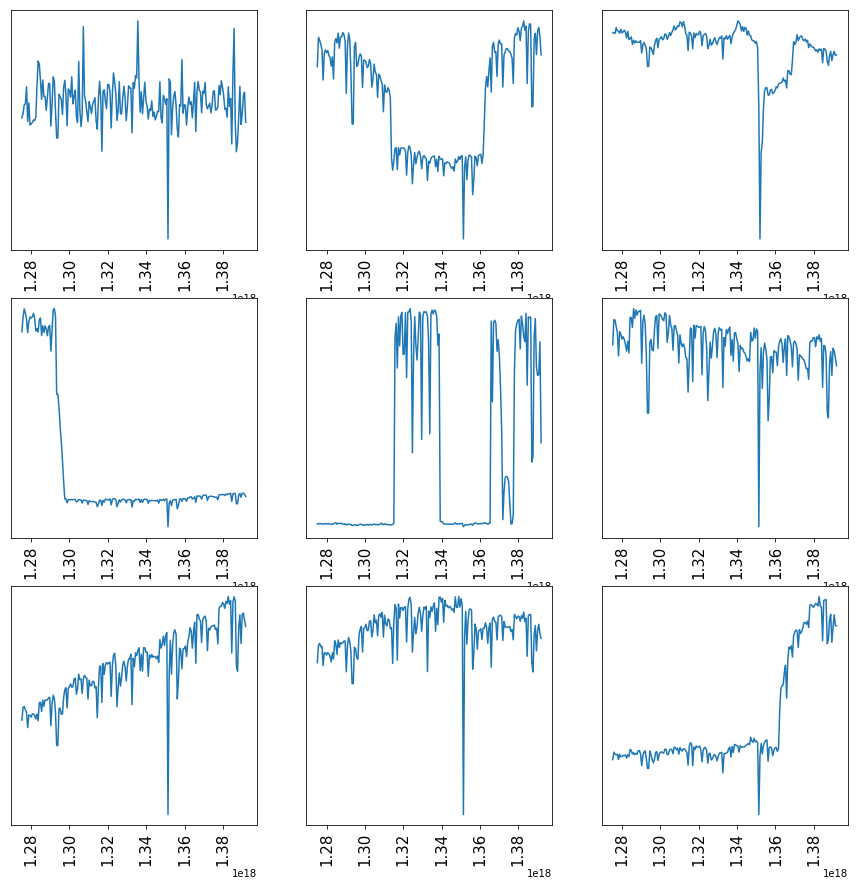

In [93]:
fig = pl.figure(figsize=(15,15))
for i,cc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(rng, cc)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
        tick.label.set_rotation('vertical')

Figure 3: K-means cluster centers (9 clusters) with random start points for all rides by type and station

In [94]:
for lab in set(km.labels_):
    print ('there are ', sum(km.labels_==lab), "time series in cluster", lab)


there are  941 time series in cluster 0
there are  831 time series in cluster 1
there are  569 time series in cluster 2
there are  1756 time series in cluster 3
there are  458 time series in cluster 4
there are  857 time series in cluster 5
there are  1796 time series in cluster 6
there are  924 time series in cluster 7
there are  1185 time series in cluster 8


In [95]:
distance = (np.array([vals - km.cluster_centers_[i]
                      for i in range (len(km.cluster_centers_))])**2)
for lab in set(km.labels_):
    print ("for cluster ", lab, "the average distance to the center is %.2f"\
           %np.mean(distance[lab][km.labels_==lab]))


for cluster  0 the average distance to the center is 0.99
for cluster  1 the average distance to the center is 0.41
for cluster  2 the average distance to the center is 0.69
for cluster  3 the average distance to the center is 0.15
for cluster  4 the average distance to the center is 0.05
for cluster  5 the average distance to the center is 0.48
for cluster  6 the average distance to the center is 0.35
for cluster  7 the average distance to the center is 0.56
for cluster  8 the average distance to the center is 0.28
